# Exercise X01.1

In [8]:
# Import the necessary libraries.
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

The following lines, the **SIR** model is presented as an *Initial Value Problem* and solved numerically using the method reported in the slide 35 of Lecture 1. A function which define the Right Hand Side of the dynamical system is defined

In [9]:
# Definition of the RHS function ( N is equal to 1 becaus ethe starting conditions are already normalized ).
def sir_model( t , y, beta , gamma , N = 1 ):
    
    # Define the system of differential equations.
    S, I, R = y
    dSdt = - beta * ( ( S * I ) / N )
    dIdt = beta * ( ( S * I ) / N ) - gamma * I
    dRdt = gamma * I
    
    return [dSdt, dIdt, dRdt]

Then, the **initial conditions**, the **parameters of the model** and the **time grid** are initialized, note that the starting conditions are already normalized, for this reason $N$ is put equal to 1.

In [10]:
# Define the initial conditions. 
y0 = [ 1 - 0.001 , 0.001 , 0 ] #y0 = [ S0 , I0 , R0 ]

# Define the parameters values.
beta = 0.8
gamma = 1./5.4
N = 1

# Define the initial and final time and the number of time steps.
ti = 0
tf = 30
n_dt = 1000
tspan = ( ti , tf ) 
tmeasurements = np.linspace( ti , tf , n_dt )

Finally, the ```solve_ivp``` function from ```scipy``` is used to integrate the system and the result is plotted.

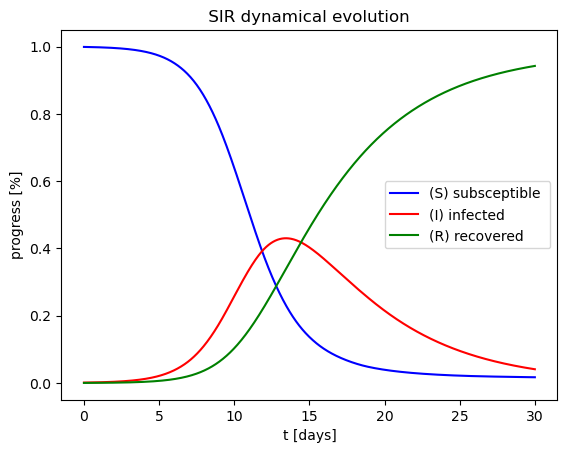

In [11]:
# Solve the system of differential equations using solve_ivp
sol = solve_ivp( lambda t, y: sir_model( t , y , beta , gamma , N ), tspan , y0 , t_eval = tmeasurements )

"""
Input description:

lambda t = the right hand side of the system is a function of t.
y = output of the "sir_model" function defined above. 
tspan = Interval of integration (t0, tf). 
y0 = Initial state.
t_eval = Times at which to store the computed solution.

"""

# Plot the results
plt.plot(sol.t, sol.y[0], "b", sol.t, sol.y[1], "r", sol.t, sol.y[2], "g")
plt.xlabel( "t [days]" )
plt.ylabel( "progress [%]" )
plt.title( " SIR dynamical evolution " )
plt.legend(["(S) subsceptible ", "(I) infected", "(R) recovered"])
plt.show()

## Physics-Informed Least Square Regression

The parameters $\beta$ and $\gamma$ can be found using the PI-LSR (Physics Informed Least Square Regression):

\begin{gather}
b=Ax\Rightarrow x=(A^{+}A^{-1})A^{+}b
\end{gather}

where $+$ indicates the complex conjugate and :

\begin{equation}
b = \begin{bmatrix}  \frac{\partial S}{\partial t} \\ \frac{\partial I}{\partial t} \\ \frac{\partial R}{\partial t}  \end{bmatrix}
\end{equation}

\begin{align}
A = \begin{bmatrix}  -\frac{SI}{N} & 0 \\ \frac{SI}{N} & -I \\ 0 & I  \end{bmatrix}
\end{align}

\begin{align}
x = \begin{bmatrix} \beta \\ \gamma \end{bmatrix}
\end{align}

In particular, we build every derivative and physical quantity as a column vector, where each row is a step forward in time. So, given the vectors $S$, $I$, and $R$, which describe how these quantities develop in time, and using the forward finite difference method to compute the respective derivatives, we can compute $x$ as shown below.

**STEP 1:** We define a function to compute the forward finite difference and obtain the first-order approximation of the derivatives of the dynamical quantities. Then, we stack the derivatives in a long column vector to obtain the solution of the above system, $b$, whose dimension will be $3\cdot time\_steps$.


In [12]:
# Define a function to compute the "Simple forward finitedifference approximations" in order to get vector b.
def FDM( x , DT ):
    
    X = x[ 0 : -2 ]
    X_prime = x[ 1 : -1 ]
    
    dXdt = ( X_prime - X ) / DT
    
    return dXdt

# Compute the dimension of a time step (here we can use this demplifications because the steps have all the same dimension).
dt = ( tf - ti ) / n_dt

# Assign to the variables a more recognizible name.
S = sol.y[0]
I = sol.y[1]
R = sol.y[2]

# Use the FDM function to get dSdt, dIdt, dRdt.
dSdt = FDM( S , dt )
dIdt = FDM( I , dt )
dRdt = FDM( R , dt )

# Reconstruct the b vector of the system b = Ax.
b = np.hstack( ( dSdt , dIdt , dRdt ) ) 

- STEP 2: We use the results of the previous exercise, $S$, $I$ and $R$ to compute the matrix $A$ of the system above, whose shape will be $(3\cdot time\_steps \times 2)$.

In [13]:
# Reconstruct matrix A of the system b = Ax.
def build_A( *args ):
    
    A = args[0]
    A = A[ : , None ]
    
    for i in range( 1 , len(args) , 1 ):
        next_col = np.expand_dims( args[i] , axis = 1 )
        A = np.concatenate( (A , next_col) , axis = 1 )
        
    return A
        
col0 = np.hstack( ( np.array( ( - ( S[ 1 : -1 ] * I[ 1 : -1 ] ) / N  ) ) ,
                    np.array( ( S[ 1 : -1 ] * I[ 1 : -1 ] ) / N ),
                    np.zeros( ( n_dt - 2 ) ) ) )

col1 = np.hstack( ( np.zeros( ( n_dt - 2 ) ),
                    np.array( - I[1 : -1] / N ),
                    np.array( I[1 : -1] / N ) ) ) 

A = build_A( col0 , col1 )

- STEP 3: Now we just need to implement the Physics-informed Least-Squares Regression, and print the results, which fit the analytical value with a nice percentage error.

In [14]:
# Implement LSR.

AT = np.conjugate(A.T)
x = np.linalg.inv( (AT @ A) ) @ AT @ b

print()
print("---> Using PI-LSR with FDM, beta computed is: {:.5f}".format(x[0]))
print("The percentage error (in absolute value) wrt the alaytical value is {:.5f}% ".format(abs(x[0]-beta)*100/beta))
print()
print("---> Using PI-LSR with FDM, gamma computed is: {:.5f}".format(x[1]))
print("The percentage error (in absolute value) wrt the alaytical value is {:.5f}% ".format(abs(x[1]-gamma)*100/gamma))


---> Using PI-LSR with FDM, beta computed is: 0.80149
The percentage error (in absolute value) wrt the alaytical value is 0.18597% 

---> Using PI-LSR with FDM, gamma computed is: 0.18516
The percentage error (in absolute value) wrt the alaytical value is 0.01609% 


## The Bathema Equations.



Bateman equation is a mathematical model that describes the abundance of a nuclide in the decay chain of isotopes. In order to calculate the population of a particular isotope, one would solve the Bateman equation governing the decay chain that includes the isotope of interest. A simple decay chain, where each nuclde has a single decay proct can be written as:

$$ X_1 \rightarrow 
\,\,\,\,\,\,
X_2 \rightarrow 
\,\,\,\,\,\,
X_3 \rightarrow ... 
$$

where $X_1$ is typically called "parent" nuclide, while $X_2$ and $X_3$ are the "daughter" and the "grand-daughter" respectively; [this link](https://periodictable.com/Isotopes/052.132/index2.full.dm.html) provides with all the decay chains of the nuclide periodic table. 

Let $N_2(t)$ and $N_3(t)$ be the population ratios of two nuclides $X_2$ and $X_3$ at time t, starting from a condition where only $X_1$ was present. We can then write how the ratios of these three populations evolve in time, given the decay constant of each of them:

$$
\frac{\partial N_1(t)}{\partial t} = -\lambda_1 N_1(t) 
$$

$$
\frac{\partial N_2(t)}{\partial t} = \lambda_1 N_1(t) -\lambda_2 N_2(t) 
$$

$$
\frac{\partial N_3(t)}{\partial t} = -\lambda_2 N_2(t) -\lambda_3 N_3(t)
$$

where:

- $\lambda_1$ is the decay constant of $X_1$ ( $s^{-1}$ ).
- $\lambda_2$ is the decay constant of $X_2$ ( $s^{-1}$ ).
- $\lambda_3$ is the decay constant of $X_3$ ( $s^{-1}$ ).

and they can be obtained numerically through their half-lives ( $\lambda = ln(2)/t_{1/2}$ ). Such system can be then solved using the same strategy as before.

**ATTENTION**: here I did assumption that there exist an instant, $t_0$, where only $X_1$ is present ( $N_1(0) = 1$ , $N_2(0)=N_3(0) = 0$ ). Beasides, I am considering am as a relative quantities and not as an absolute number of nuclides.

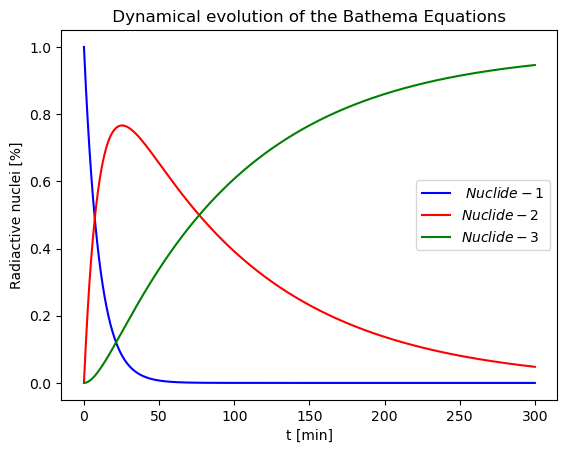

In [15]:
# Import the necessary libraries.
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# RHS function.
def sir_model( t , y, lambda1 , lambda2 , lambda3 ):
    # Define the system of differential equations.
    N1, N2, N3 = y
    dN1dt = - lambda1 * N1
    dN2dt = lambda1 * N1 - lambda2 * N2
    dN3dt = lambda2 * N2 - lambda3 * N3
    return [dN1dt, dN2dt, dN3dt]

# Define the initial conditions and parameters values
y0 = [ 1 , 0 , 0 ] #[N1(0), N2(0), N3(0)]
l1 = 0.693 / 7     # t1/2 = 7 min (Cadmium-103)
l2 = 0.693 / 66    # t1/2 = 66 min (Silver-103)
l3 = 0.693 / 23040 # t1/2 = 16 days (Palladium-103)

ti = 0
tf = 300
n_dt = 10000
tspan = ( ti , tf ) 

# Solve the system of differential equations using solve_ivp
tmeasurements = np.linspace( ti , tf , n_dt )
sol = solve_ivp( lambda t, y: sir_model( t , y , l1 , l2, l3 ), tspan , y0 , t_eval = tmeasurements )

# Plot the results
plt.plot(sol.t, sol.y[0], "b", sol.t, sol.y[1], "r", sol.t, sol.y[2], "g")
plt.xlabel( "t [min]" )
plt.ylabel( "Radiactive nuclei [%]" )
plt.title( " Dynamical evolution of the Bathema Equations " )
plt.legend([" $Nuclide-1$ ", "$Nuclide-2$", "$Nuclide-3$"])
plt.show()

In this case I used:
- Nuclide1 = Cadmium-103.
- Nuclide2 = Silver-103.
- Nuclide3 = Palladium-103.

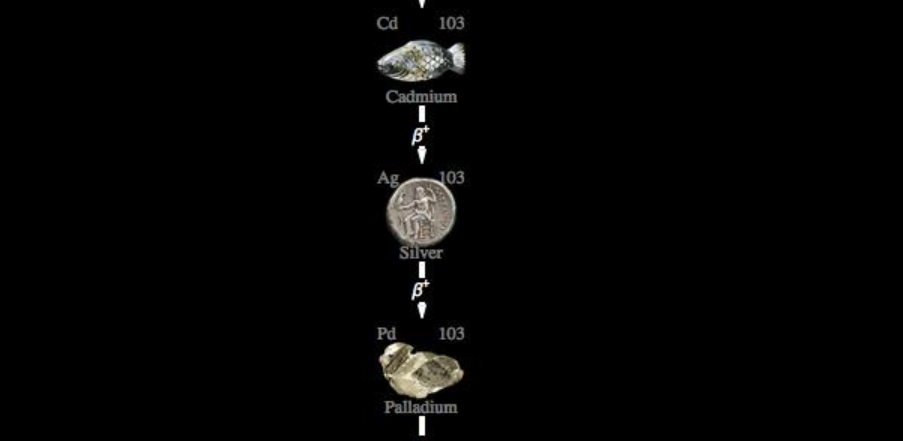

In [1]:
from IPython import display
display.Image("./Img/decay_chain.png", embed = True)

The father and the doughter have comparable half-lives, while the grandoughter is more stable. Many other really existing chains could be traied by looking at the link provided above. Now we can use the PI-LSR to find the decay constants from the generated data:

In [16]:
# Compute the dimension of a time step (here we can use this demplifications because the steps have all the same dimension).
dt = ( tf - ti ) / n_dt

# Assign to the variables a more recognizible name.
N1 = sol.y[0]
N2 = sol.y[1]
N3 = sol.y[2]

# Use the FDM function to get dSdt, dIdt, dRdt.
dN1dt = FDM( N1 , dt )
dN2dt = FDM( N2 , dt )
dN3dt = FDM( N3 , dt )

# Reconstruct the b vector of the system b = Ax.
b = np.hstack( ( dN1dt , dN2dt , dN3dt ) ) 
        
col0 = np.hstack( ( np.array( - N1[ 1 : - 1] ) ,
                    np.array( N1[ 1 : - 1]  ),
                    np.zeros( ( n_dt - 2 ) ) 
                  ) )

col1 = np.hstack( ( np.zeros( ( n_dt - 2 ) ),
                    np.array( - N2[ 1 : - 1] ),
                    np.array( N2[ 1 : - 1] ) 
                  ) ) 

col2 = np.hstack( ( np.zeros( ( n_dt - 2 ) ),
                    np.zeros( ( n_dt - 2 ) ),
                    np.array( -N3[ 1 : - 1] ) 
                  ) ) 

A = build_A( col0 , col1 , col2 )

# Implement LSR.
AT = np.conjugate(A.T)
z = np.linalg.inv( (AT @ A) ) @ AT @ b

print()
print("---> Using PI-LSR with FDM, beta computed is: {:.5f}".format(z[0]))
print("The percentage error (in absolute value) wrt the alaytical value is {:.5f}% ".format(abs(z[0]-l1)*100/l1))
print()
print("---> Using PI-LSR with FDM, gamma computed is: {:.5f}".format(z[1]))
print("The percentage error (in absolute value) wrt the alaytical value is {:.5f}% ".format(abs(z[1]-l2)*100/l2))
print()
print("---> Using PI-LSR with FDM, gamma computed is: {:.5f}".format(z[2]))
print("The percentage error (in absolute value) wrt the alaytical value is {:.5f}% ".format(abs(z[2]-l3)*100/l3))


---> Using PI-LSR with FDM, beta computed is: 0.09917
The percentage error (in absolute value) wrt the alaytical value is 0.17005% 

---> Using PI-LSR with FDM, gamma computed is: 0.01050
The percentage error (in absolute value) wrt the alaytical value is 0.02347% 

---> Using PI-LSR with FDM, gamma computed is: 0.00003
The percentage error (in absolute value) wrt the alaytical value is 0.10708% 
